In [47]:
# prompt: Make a function where I input a text file of timestamps and events in the format - 00:00 {lost, bust} where the time is in minute:seconds and everything inside of the braces is the comment. Can you convert the whole file into lines like this: plt.axvline(x={timestamp, in seconds}, color={color}, linestyle='--', label={comment}). I want losses to be red, wins to be green, neutral statements to be black, and pushes to be yellow.

import matplotlib.pyplot as plt
def generate_event_lines(event_file):
  """
  Reads an event file and generates plot lines for events.

  Args:
      event_file (str): Path to the text file containing events.

  Returns:
      list: A list of strings, where each string is a plt.axvline call.
  """
  lines_to_plot = []
  with open(event_file, 'r') as f:
    for line in f:
      line = line.strip()
      if not line:
        continue

      parts = line.split('{')
      if len(parts) != 2:
        print(f"Warning: Skipping invalid line format: {line}")
        continue

      time_str = parts[0].strip()
      comment_str = parts[1].strip('} ').strip()

      try:
        minutes, seconds = map(int, time_str.split(':'))
        timestamp_seconds = minutes * 60 + seconds
      except ValueError:
        print(f"Warning: Skipping line with invalid timestamp format: {line}")
        continue

      # Determine color based on comment
      color = 'black'  # Default color
      if 'loss' in comment_str.lower():
        color = 'red'
      elif 'win' in comment_str.lower():
        color = 'green'
      elif 'push' in comment_str.lower():
        color = 'yellow'

      # Create the plot line string
      plot_line = f"plt.axvline(x={timestamp_seconds}, color='{color}', linestyle='--')"
      lines_to_plot.append(plot_line)

  return lines_to_plot

# Example usage:
# Assuming your event file is named 'events.txt'
# event_lines = generate_event_lines('events.txt')
# for line in event_lines:
#     print(line)

# To integrate this into your plotting functions, you would call generate_event_lines
# and then execute the generated lines after your main plot calls but before plt.show().
# For example, within the plot_affect_over_duration function:
#
# def plot_affect_over_duration(filename, event_file=None, switch=180):
#   # ... (existing code)
#
#   # Add event lines if event_file is provided
#   if event_file:
#       event_plot_lines = generate_event_lines(event_file)
#       for plot_line in event_plot_lines:
#           exec(plot_line) # Use exec to run the generated string as code
#
#   # ... (existing code)
#
#   plt.legend() # Make sure legend is called after adding all labels
#   plt.grid(True)
#   plt.tight_layout()
#   plt.show()

In [48]:
# prompt: Make a function plot the affect values over duration. The format of the txt data is Timestamp,Local time,Active Focus,Focus,Active Engagement,Engagement,Active Excitement,Excitement,Active Interest,Interest,Active Relaxation,Relaxation,Active Stress,Stress. Ignore the local time and  active labels. Convert the time stamps (that has format 1749332417.7556 which are seconds.milliseconds) to a duration starting with the first value at time 00:00:00 (mm:ss:ms). Put a vertical line on the plot at 3:00:00 minutes with the label "Switched to Real $" and only display x tick marks every 30 seconds.

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_affect_over_duration(filename, annotations, switch=180):
    """
    Plots the affect values over duration from a text file.

    Args:
        filename (str): The path to the text file.
    """
    df = pd.read_csv(filename, sep=',', header=0)

    # Convert timestamp to duration (in seconds)
    start_time = df['Timestamp'].iloc[0]
    df['Duration'] = df['Timestamp'] - start_time

    # Select relevant columns
    affect_columns = ['Focus', 'Engagement', 'Excitement', 'Interest', 'Relaxation', 'Stress']

    plt.figure(figsize=(15, 8))

    # Plot each affect over time
    for col in affect_columns:
        plt.plot(df['Duration'], df[col], label=col)

    # Vertical line at 3 minutes (180 seconds)
    lines = generate_event_lines(annotations)
    for line in lines:
      exec(line)
    plt.axvline(x=int(switch), color='c', linestyle='--', label='Switched to Real $')

    # Format x-ticks every 30 seconds
    max_duration = df['Duration'].max()
    tick_positions = list(range(0, int(max_duration) + 30, 30))
    plt.xticks(tick_positions)

    def format_mmssms(x, pos):
        minutes = int(x // 60)
        seconds = int(x % 60)
        milliseconds = int((x - int(x)) * 1000)
        return f"{minutes:02}:{seconds:02}:{milliseconds:03}"

    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_mmssms))

    plt.xlabel("Duration (mm:ss:ms)")
    plt.ylabel("Affect Value")
    plt.title("Affect Values Over Duration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [49]:
# prompt: Can you rewrite the plot_affect_over_duration but filter out values whose 'active' value in the csv is false for the respective label. For example if "Active Focus" is false, ignore plotting the Focus value in that same row. This value is stored in the same file as the first argument. Therefore, you do not need to rewrite the generate_event_lines functions.

import pandas as pd
import matplotlib.pyplot as plt
def plot_affect_over_duration(filename, annotations, switch=180):
    """
    Plots the affect values over duration from a text file,
    filtering out data points where the corresponding 'Active' status is False.

    Args:
        filename (str): The path to the CSV file.
        annotations (str): The path to the annotations file.
        switch (int): The time in seconds to draw a vertical line (default 180).
    """
    df = pd.read_csv(filename, sep=',', header=0)

    # Convert timestamp to duration (in seconds)
    start_time = df['Timestamp'].iloc[0]
    df['Duration'] = df['Timestamp'] - start_time

    # Select relevant affect and active status columns
    affect_columns = ['Focus', 'Engagement', 'Excitement', 'Interest', 'Relaxation', 'Stress']
    active_columns = [f'Active {col}' for col in affect_columns]

    plt.figure(figsize=(15, 8))

    # Plot each affect over time, filtered by active status
    for i, col in enumerate(affect_columns):
        active_col = active_columns[i]
        # Filter rows where the corresponding active column is True
        filtered_df = df[df[active_col] == True]
        plt.plot(filtered_df['Duration'], filtered_df[col], label=col)

    # Vertical line at the switch time
    lines = generate_event_lines(annotations)
    for line in lines:
      exec(line)
    plt.axvline(x=int(switch), color='c', linestyle='--', label='Switched to Real $')

    # Format x-ticks every 30 seconds
    max_duration = df['Duration'].max()
    tick_positions = list(range(0, int(max_duration) + 30, 30))
    plt.xticks(tick_positions)

    def format_mmssms(x, pos):
        minutes = int(x // 60)
        seconds = int(x % 60)
        # Ensure milliseconds are positive
        milliseconds = int((x - int(x)) * 1000) if x > 0 else 0
        return f"{minutes:02}:{seconds:02}:{milliseconds:03}"

    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_mmssms))

    plt.xlabel("Duration (mm:ss:ms)")
    plt.ylabel("Affect Value")
    plt.title("Affect Values Over Duration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [50]:
# prompt: Write the same function as plot_affect_over_duration but with PAD values and the file has header format: Timestamp,Local time,Pleasure,Arousal,Dominance.

import pandas as pd
import matplotlib.pyplot as plt
def plot_pad_over_duration(filename, annotations, switch=180):
    """
    Plots the PAD values over duration from a text file.

    Args:
        filename (str): The path to the text file.
    """
    df = pd.read_csv(filename, sep=',', header=0)

    # Convert timestamp to duration (in seconds)
    start_time = df['Timestamp'].iloc[0]
    df['Duration'] = df['Timestamp'] - start_time

    # Select relevant columns
    pad_columns = ['Pleasure', 'Arousal', 'Dominance']

    plt.figure(figsize=(15, 8))

    # Plot each PAD value over time
    for col in pad_columns:
        plt.plot(df['Duration'], df[col], label=col)

    # Vertical line at 3 minutes (180 seconds) - if applicable to this data
    lines = generate_event_lines(annotations)
    for line in lines:
      exec(line)
    plt.axvline(x=int(switch), color='c', linestyle='--', label='Switched to Real $')

    # Format x-ticks every 30 seconds
    max_duration = df['Duration'].max()
    tick_positions = list(range(0, int(max_duration) + 30, 30))
    plt.xticks(tick_positions)

    def format_mmssms(x, pos):
        minutes = int(x // 60)
        seconds = int(x % 60)
        milliseconds = int((x - int(x)) * 1000)
        return f"{minutes:02}:{seconds:02}:{milliseconds:03}"

    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_mmssms))

    plt.xlabel("Duration (mm:ss:ms)")
    plt.ylabel("PAD Value")
    plt.title("PAD Values Over Duration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [51]:
# prompt: write a similar function to the plot_PAD_over_duration for a file with this format: Timestamp,Local time,Battery Level,Battery Percent,Wireless Signal,Overall Quality,Quality Sensor 0,Quality Sensor 1,Quality Sensor 2,Quality Sensor 3,Quality Sensor 4. Ignore battery leverl, battery percent, wireless signal, and overall quality.

import pandas as pd
import matplotlib.pyplot as plt
def plot_device_over_duration(filename, switch=180):
    """
    Plots the Quality Sensor values over duration from a text file.

    Args:
        filename (str): The path to the text file.
    """
    df = pd.read_csv(filename, sep=',', header=0)

    # Convert timestamp to duration (in seconds)
    start_time = df['Timestamp'].iloc[0]
    df['Duration'] = df['Timestamp'] - start_time

    # Select relevant columns
    quality_columns = ['Quality Sensor 0', 'Quality Sensor 1', 'Quality Sensor 2', 'Quality Sensor 3', 'Quality Sensor 4']

    plt.figure(figsize=(15, 8))

    # Plot each Quality Sensor over time
    for col in quality_columns:
        plt.plot(df['Duration'], df[col], label=col)

    # Vertical line at 3 minutes (180 seconds) - if applicable to this data
    plt.axvline(x=int(switch), color='c', linestyle='--', label='Switched to Real $')

    # Format x-ticks every 30 seconds
    max_duration = df['Duration'].max()
    tick_positions = list(range(0, int(max_duration) + 30, 30))
    plt.xticks(tick_positions)

    def format_mmssms(x, pos):
        minutes = int(x // 60)
        seconds = int(x % 60)
        milliseconds = int((x - int(x)) * 1000)
        return f"{minutes:02}:{seconds:02}:{milliseconds:03}"

    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_mmssms))


    plt.xlabel("Duration (mm:ss:ms)")
    plt.ylabel("Quality Sensor Value")
    plt.title("Quality Sensor Values Over Duration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [52]:
# prompt: Can you create a function that takes in a file, a label, and a time stamp in seconds to divide two periods. Then returns the mean, variance, and standard deviation before and after that time stamp.

import pandas as pd

def calculate_stats(filename, label, split_time):
  """
  Analyzes the mean, variance, and standard deviation of a label in a file
  before and after a specified time split.

  Args:
      filename (str): The path to the text file.
      label (str): The name of the column (label) to analyze.
      split_time (int or float): The time in seconds to split the data.

  Returns:
      dict: A dictionary containing the mean, variance, and standard deviation
            for the data before and after the split time.
  """
  df = pd.read_csv(filename, sep=',', header=0)

  # Convert timestamp to duration (in seconds)
  start_time = df['Timestamp'].iloc[0]
  df['Duration'] = df['Timestamp'] - start_time

  # Split the data based on the split_time
  df_before = df[df['Duration'] < split_time]
  df_after = df[df['Duration'] >= split_time]

  # Calculate statistics for the period before the split
  mean_before = df_before[label].mean()
  variance_before = df_before[label].var()
  std_dev_before = df_before[label].std()

  # Calculate statistics for the period after the split
  mean_after = df_after[label].mean()
  variance_after = df_after[label].var()
  std_dev_after = df_after[label].std()

  results = {
      'before_split': {
          'mean': mean_before,
          'variance': variance_before,
          'std_dev': std_dev_before
      },
      'after_split': {
          'mean': mean_after,
          'variance': variance_after,
          'std_dev': std_dev_after
      }
  }

  return results

# Example usage:
# Assuming you have a file named 'your_data.txt' and want to analyze 'Focus' at 180 seconds
# analysis_results = analyze_data_split('your_data.txt', 'Focus', 180)
# print(analysis_results)


In [59]:
# prompt: Can you rewrite the calculating statistics so that it only uses values when the respective "active" value is True. This is similar to the revisions made for plot_affect_over_duration.

import pandas as pd
def calculate_stats_filter(filename, label, split_time):
  """
  Analyzes the mean, variance, and standard deviation of a label in a file
  before and after a specified time split, only using values where the
  corresponding 'Active' status is True.

  Args:
      filename (str): The path to the CSV file.
      label (str): The name of the column (label) to analyze (e.g., 'Focus').
      split_time (int or float): The time in seconds to split the data.

  Returns:
      dict: A dictionary containing the mean, variance, and standard deviation
            for the data before and after the split time. Returns None if the
            active status column for the label does not exist.
  """
  df = pd.read_csv(filename, sep=',', header=0)

  # Convert timestamp to duration (in seconds)
  start_time = df['Timestamp'].iloc[0]
  df['Duration'] = df['Timestamp'] - start_time

  # Determine the corresponding active status column
  active_col = f'Active {label}'

  # Check if the active column exists
  if active_col not in df.columns:
    print(f"Warning: Active status column '{active_col}' not found for label '{label}'. Cannot calculate filtered statistics.")
    return None

  # Filter the dataframe to include only rows where the active status is True
  df_active = df[df[active_col] == True]

  # Split the filtered data based on the split_time
  df_active_before = df_active[df_active['Duration'] < split_time]
  df_active_after = df_active[df_active['Duration'] >= split_time]

  # Calculate statistics for the period before the split (on filtered data)
  mean_before = df_active_before[label].mean()
  variance_before = df_active_before[label].var()
  std_dev_before = df_active_before[label].std()

  # Calculate statistics for the period after the split (on filtered data)
  mean_after = df_active_after[label].mean()
  variance_after = df_active_after[label].var()
  std_dev_after = df_active_after[label].std()

  results = {
      'before_split': {
          'mean': mean_before,
          'variance': variance_before,
          'std_dev': std_dev_before
      },
      'after_split': {
          'mean': mean_after,
          'variance': variance_after,
          'std_dev': std_dev_after
      }
  }

  return results


In [70]:
# prompt: Can you write a functions that determines if the before_split and after_split results have a statistically significant difference with a p-value of 0.05. I can supply you with the original data file, the split timestamp in seconds, and the label. This functions should again filter the data for points with a false "active" label.

import pandas as pd
from scipy.stats import ttest_ind

def check_statistical_significance_filtered(filename, label, split_time, alpha=0.01):
  """
  Performs an independent samples t-test to check for a statistically significant
  difference in the mean of a label before and after a split time, only using
  values where the corresponding 'Active' status is True.

  Args:
      filename (str): The path to the CSV file.
      label (str): The name of the column (label) to analyze (e.g., 'Focus').
      split_time (int or float): The time in seconds to split the data.
      alpha (float): The significance level (default 0.05).

  Returns:
      dict or None: A dictionary containing the t-statistic, p-value, and
                    a boolean indicating if the difference is statistically
                    significant. Returns None if the active status column
                    for the label does not exist or if either group has fewer
                    than 2 data points.
  """
  df = pd.read_csv(filename, sep=',', header=0)

  # Convert timestamp to duration (in seconds)
  start_time = df['Timestamp'].iloc[0]
  df['Duration'] = df['Timestamp'] - start_time

  # Determine the corresponding active status column
  active_col = f'Active {label}'

  # Check if the active column exists
  if active_col not in df.columns:
    print(f"Warning: Active status column '{active_col}' not found for label '{label}'. Cannot perform significance test.")
    return None

  # Filter the dataframe to include only rows where the active status is True
  df_active = df[df[active_col] == True]

  # Split the filtered data based on the split_time
  data_before = df_active[df_active['Duration'] < split_time][label].dropna()
  data_after = df_active[df_active['Duration'] >= split_time][label].dropna()

  # Ensure there are enough data points in each group for the t-test
  if len(data_before) < 2 or len(data_after) < 2:
    print(f"Warning: Not enough data points (less than 2) in one or both groups for label '{label}'. Cannot perform significance test.")
    return None

  # Perform independent samples t-test
  t_statistic, p_value = ttest_ind(data_before, data_after)

  # Determine if the difference is statistically significant
  is_significant = p_value < alpha

  results = {
      't_statistic': t_statistic,
      'p_value': p_value,
      'statistically_significant': is_significant
  }

  return results



In [71]:
# prompt: Can you write a functions that determines if the before_split and after_split results have a statistically significant difference with a p-value of 0.05. I can supply you with the original data file, the split timestamp in seconds, and the label. This functions should again filter the data for points with a false "active" label.

import pandas as pd
from scipy.stats import ttest_ind

def check_statistical_significance(filename, label, split_time, alpha=0.01):
  """
  Performs an independent samples t-test to check for a statistically significant
  difference in the mean of a label before and after a split time, only using
  values where the corresponding 'Active' status is True.

  Args:
      filename (str): The path to the CSV file.
      label (str): The name of the column (label) to analyze (e.g., 'Focus').
      split_time (int or float): The time in seconds to split the data.
      alpha (float): The significance level (default 0.05).

  Returns:
      dict or None: A dictionary containing the t-statistic, p-value, and
                    a boolean indicating if the difference is statistically
                    significant. Returns None if the active status column
                    for the label does not exist or if either group has fewer
                    than 2 data points.
  """
  df = pd.read_csv(filename, sep=',', header=0)

  # Convert timestamp to duration (in seconds)
  start_time = df['Timestamp'].iloc[0]
  df['Duration'] = df['Timestamp'] - start_time

  # Split the filtered data based on the split_time
  data_before = df[df['Duration'] < split_time][label].dropna()
  data_after = df[df['Duration'] >= split_time][label].dropna()

  # Ensure there are enough data points in each group for the t-test
  if len(data_before) < 2 or len(data_after) < 2:
    print(f"Warning: Not enough data points (less than 2) in one or both groups for label '{label}'. Cannot perform significance test.")
    return None

  # Perform independent samples t-test
  t_statistic, p_value = ttest_ind(data_before, data_after)

  # Determine if the difference is statistically significant
  is_significant = p_value < alpha

  results = {
      't_statistic': t_statistic,
      'p_value': p_value,
      'statistically_significant': is_significant
  }

  return results



In [72]:
def perform_statistical_analysis_affect(f, switch):
    for label in ['Focus', 'Engagement', 'Excitement', 'Interest', 'Relaxation', 'Stress']:
      print(f"{label}")
      print(calculate_stats_filter(f, label, switch))
      f.seek(0)
      print(check_statistical_significance_filtered(f, label, switch))
      f.seek(0)

In [73]:
def perform_statistical_analysis_pad(f, switch):
    for label in ['Pleasure', 'Arousal', 'Dominance']:
      print(f"{label}")
      print(calculate_stats(f, label, switch))
      f.seek(0)
      print(check_statistical_significance(f, label, switch))
      f.seek(0)

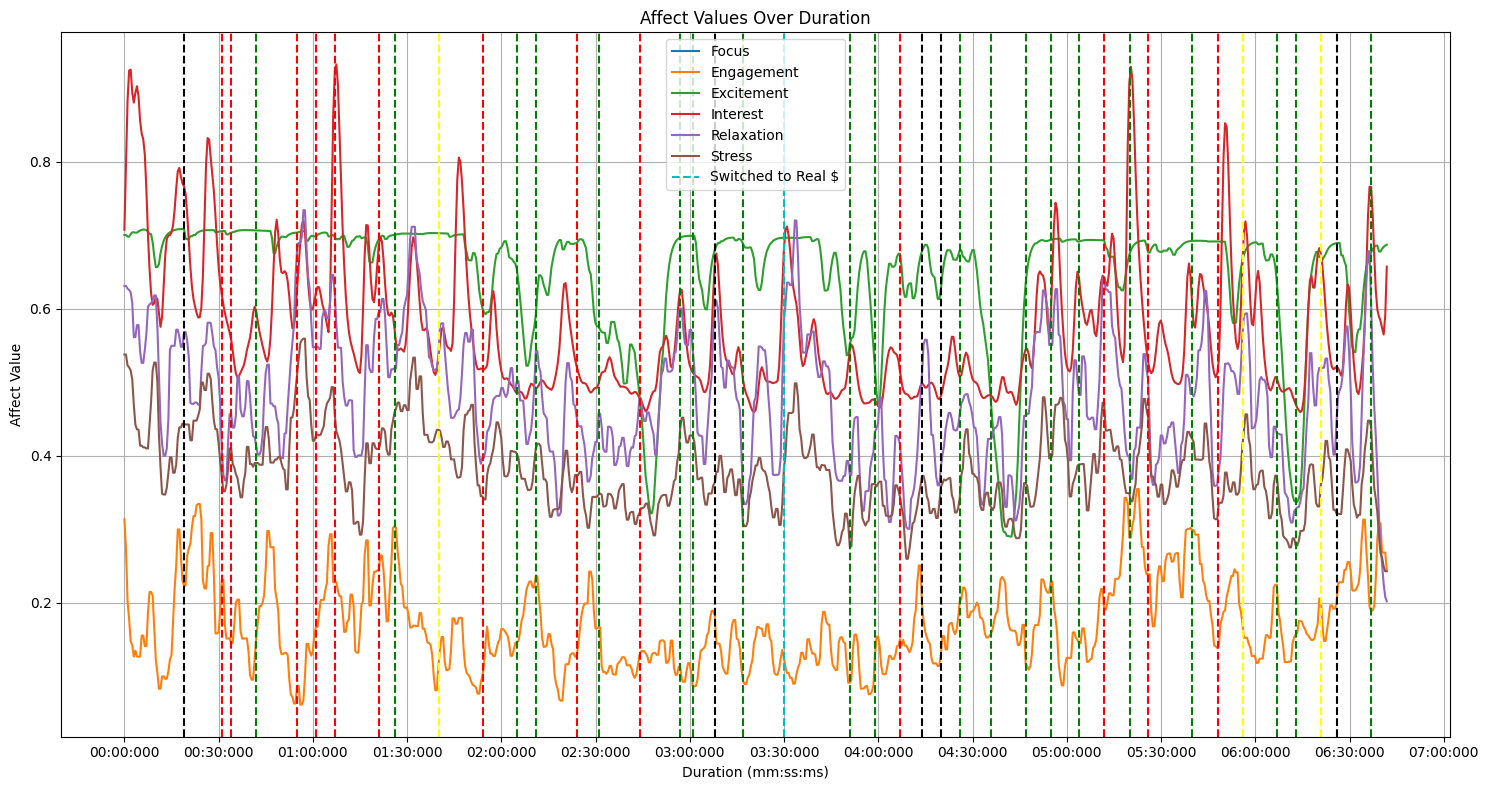

Focus
{'before_split': {'mean': nan, 'variance': nan, 'std_dev': nan}, 'after_split': {'mean': nan, 'variance': nan, 'std_dev': nan}}
None
Engagement
{'before_split': {'mean': 0.1610321163895487, 'variance': 0.003370763796250707, 'std_dev': 0.05805827930838725}, 'after_split': {'mean': 0.18043407031250003, 'variance': 0.003433244359371022, 'std_dev': 0.05859389353312359}}
{'t_statistic': -4.714967171057367, 'p_value': 2.8497801915116283e-06, 'statistically_significant': True}
Excitement
{'before_split': {'mean': 0.6636846460807602, 'variance': 0.004886334328681587, 'std_dev': 0.06990231990915313}, 'after_split': {'mean': 0.6331660677083334, 'variance': 0.008977416534434046, 'std_dev': 0.09474922973003023}}
{'t_statistic': 5.230226007134364, 'p_value': 2.161586818226284e-07, 'statistically_significant': True}
Interest
{'before_split': {'mean': 0.5868066959619953, 'variance': 0.010302437473926384, 'std_dev': 0.10150092351267738}, 'after_split': {'mean': 0.5607811145833334, 'variance': 0.

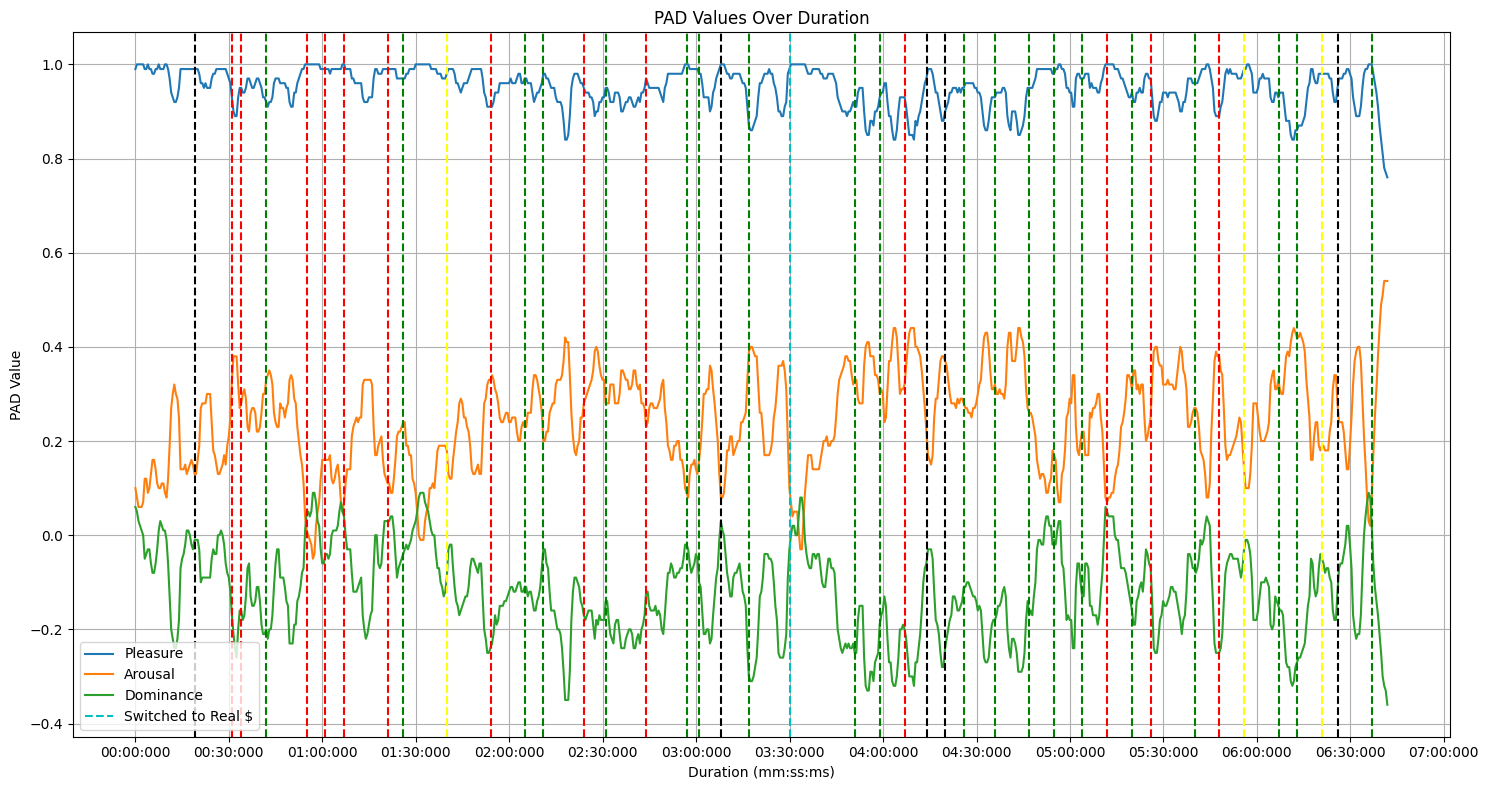

Pleasure
{'before_split': {'mean': 0.9606413301662708, 'variance': 0.0010360162877502534, 'std_dev': 0.03218720689575679}, 'after_split': {'mean': 0.9413802083333334, 'variance': 0.002034904672541342, 'std_dev': 0.04510991767384798}}
{'t_statistic': 7.018594410487199, 'p_value': 4.770329483880269e-12, 'statistically_significant': True}
Arousal
{'before_split': {'mean': 0.2209501187648456, 'variance': 0.008793857029747741, 'std_dev': 0.0937755673389809}, 'after_split': {'mean': 0.27005208333333336, 'variance': 0.011295036444734546, 'std_dev': 0.10627810896292117}}
{'t_statistic': -6.96296017114543, 'p_value': 6.932600787403628e-12, 'statistically_significant': True}
Dominance
{'before_split': {'mean': -0.10510688836104513, 'variance': 0.007989333785770835, 'std_dev': 0.08938307326206028}, 'after_split': {'mean': -0.13432291666666665, 'variance': 0.009553587358572651, 'std_dev': 0.09774245422830681}}
{'t_statistic': 4.429839003869346, 'p_value': 1.073763793651508e-05, 'statistically_sign

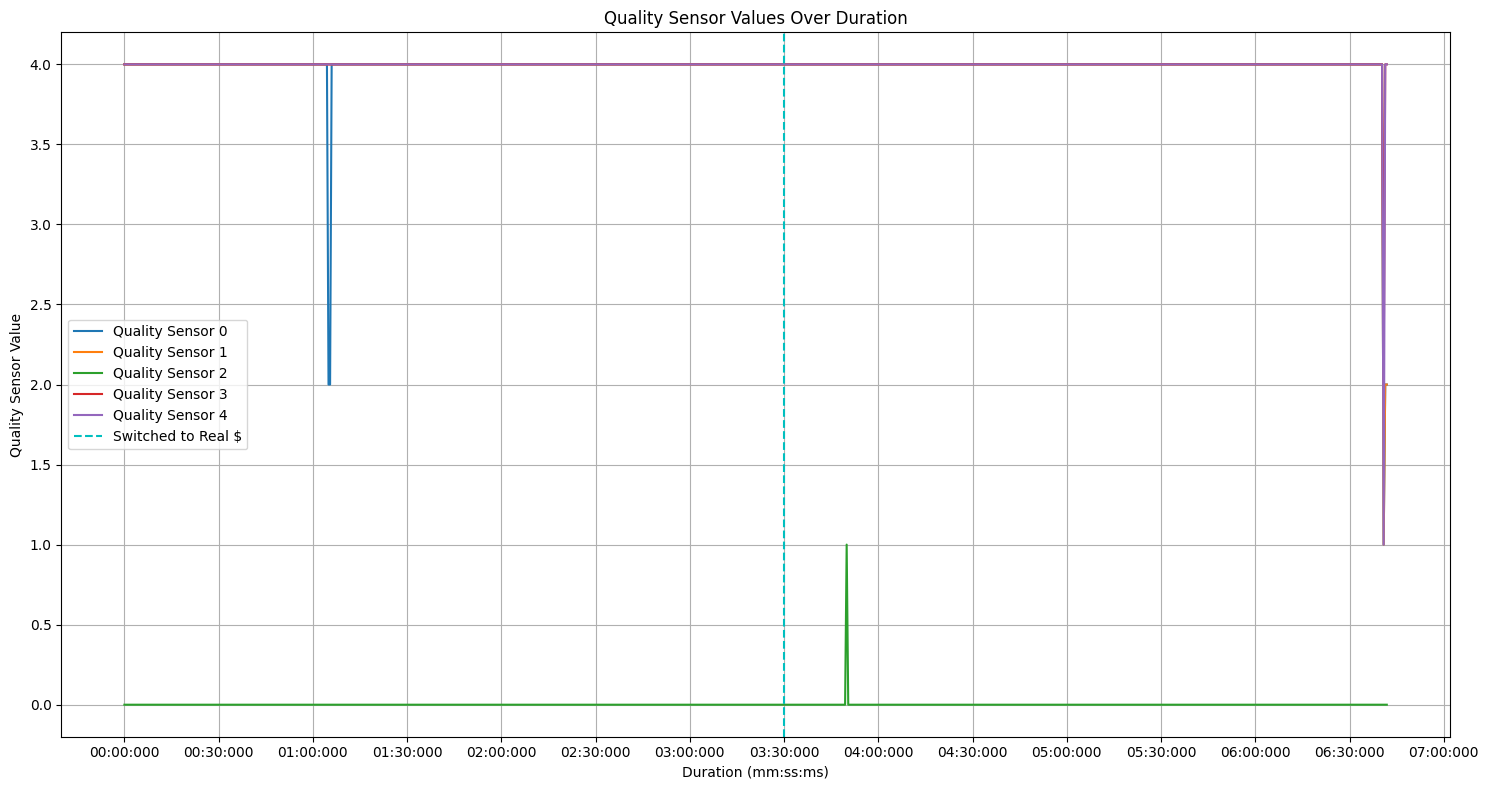

In [74]:
# prompt: open the Ethan 1 folder and open each file for reading

import os

folder_path = '/content/drive/MyDrive/CSC 570 - Affective Computing/GamblingAffect/Ethan/Emotiv/Ethan 1'
switch = 210

# Check if the folder exists
if os.path.isdir(folder_path):
  i=0
  # List all files in the folder
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    # Check if the path is a file
    if os.path.isfile(file_path):
      try:
        with open(file_path, 'r') as f:
          if filename == '250607144017_AFFECT.txt':
            plot_affect_over_duration(f, os.path.join(folder_path, 'tobyannotations.txt'), switch)
            f.seek(0)
            perform_statistical_analysis_affect(f, switch)

          elif filename == '250607144017_PAD.txt':
            plot_pad_over_duration(f, os.path.join(folder_path, 'tobyannotations.txt'), switch)
            f.seek(0)
            perform_statistical_analysis_pad(f, switch)

          elif filename == '250607144017_DEVICE.txt':
            plot_device_over_duration(f, switch)

      except Exception as e:
        print(f"Error opening or reading file {file_path}: {e}")
else:
  print(f"Folder not found: {folder_path}")

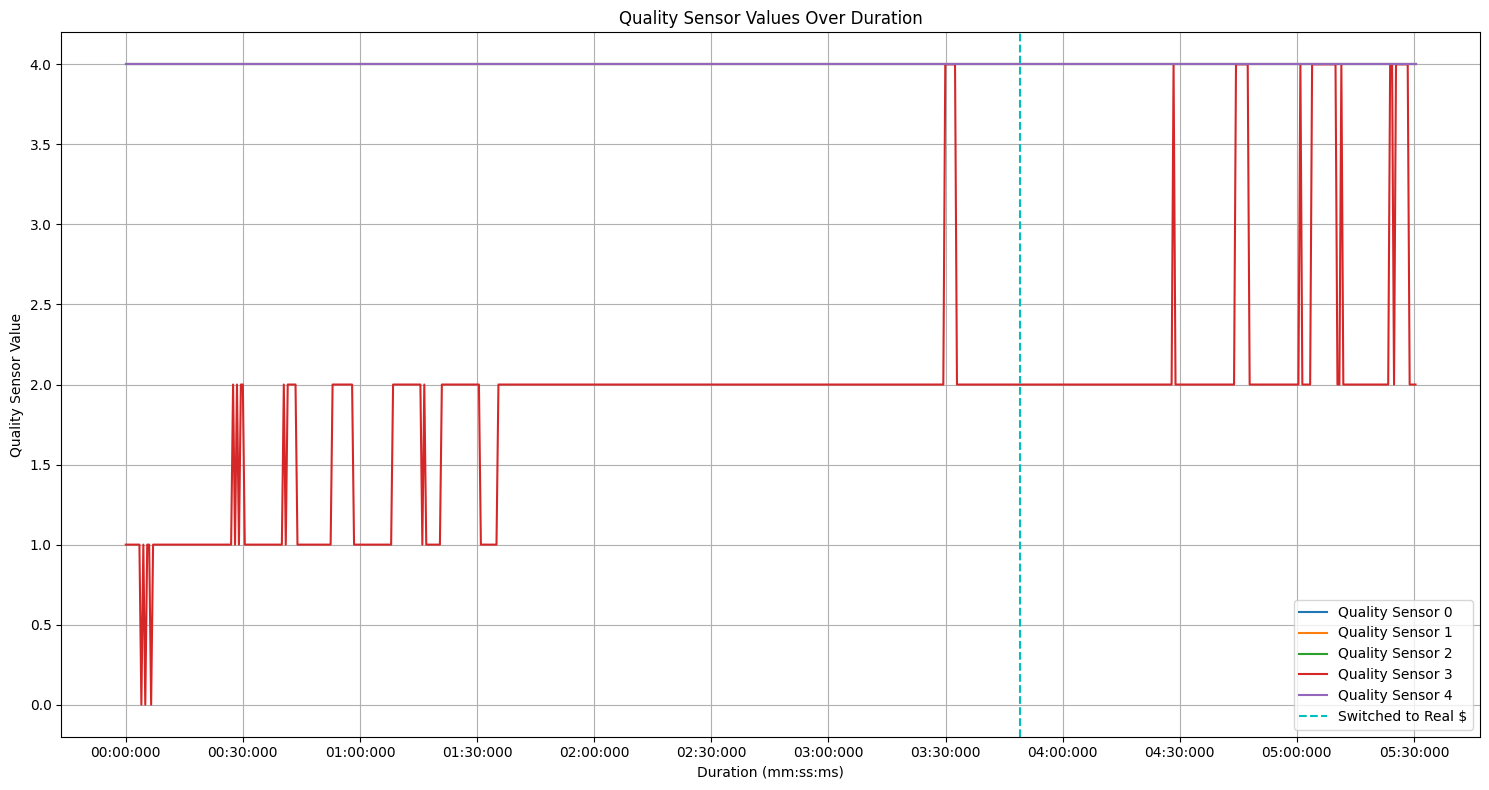

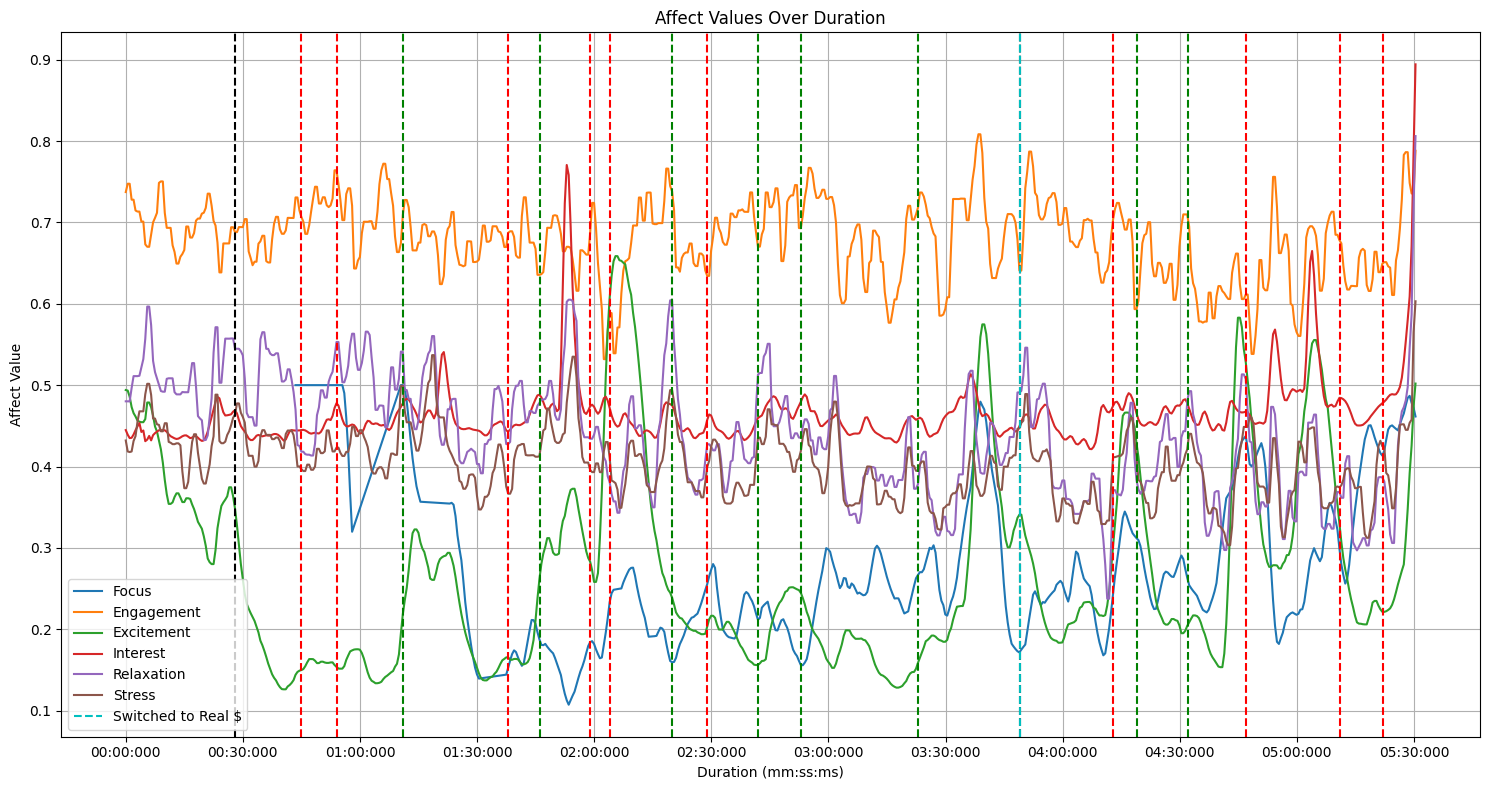

Focus
{'before_split': {'mean': 0.24525141806020068, 'variance': 0.00698595990826424, 'std_dev': 0.08358205494162153}, 'after_split': {'mean': 0.3019674334975369, 'variance': 0.0070992857703953095, 'std_dev': 0.08425725945219978}}
{'t_statistic': -7.437139961147982, 'p_value': 4.5084216358918933e-13, 'statistically_significant': True}
Engagement
{'before_split': {'mean': 0.6873006100217864, 'variance': 0.0018606365035266244, 'std_dev': 0.043135095960558895}, 'after_split': {'mean': 0.661560684729064, 'variance': 0.0027484374466822882, 'std_dev': 0.052425541930268}}
{'t_statistic': 6.613062853254024, 'p_value': 7.778207988355439e-11, 'statistically_significant': True}
Excitement
{'before_split': {'mean': 0.25694664052287586, 'variance': 0.014734833390798433, 'std_dev': 0.12138712201382168}, 'after_split': {'mean': 0.29829960591133003, 'variance': 0.01262654344713106, 'std_dev': 0.11236789331090559}}
{'t_statistic': -4.133169086254259, 'p_value': 4.038945050825452e-05, 'statistically_sig

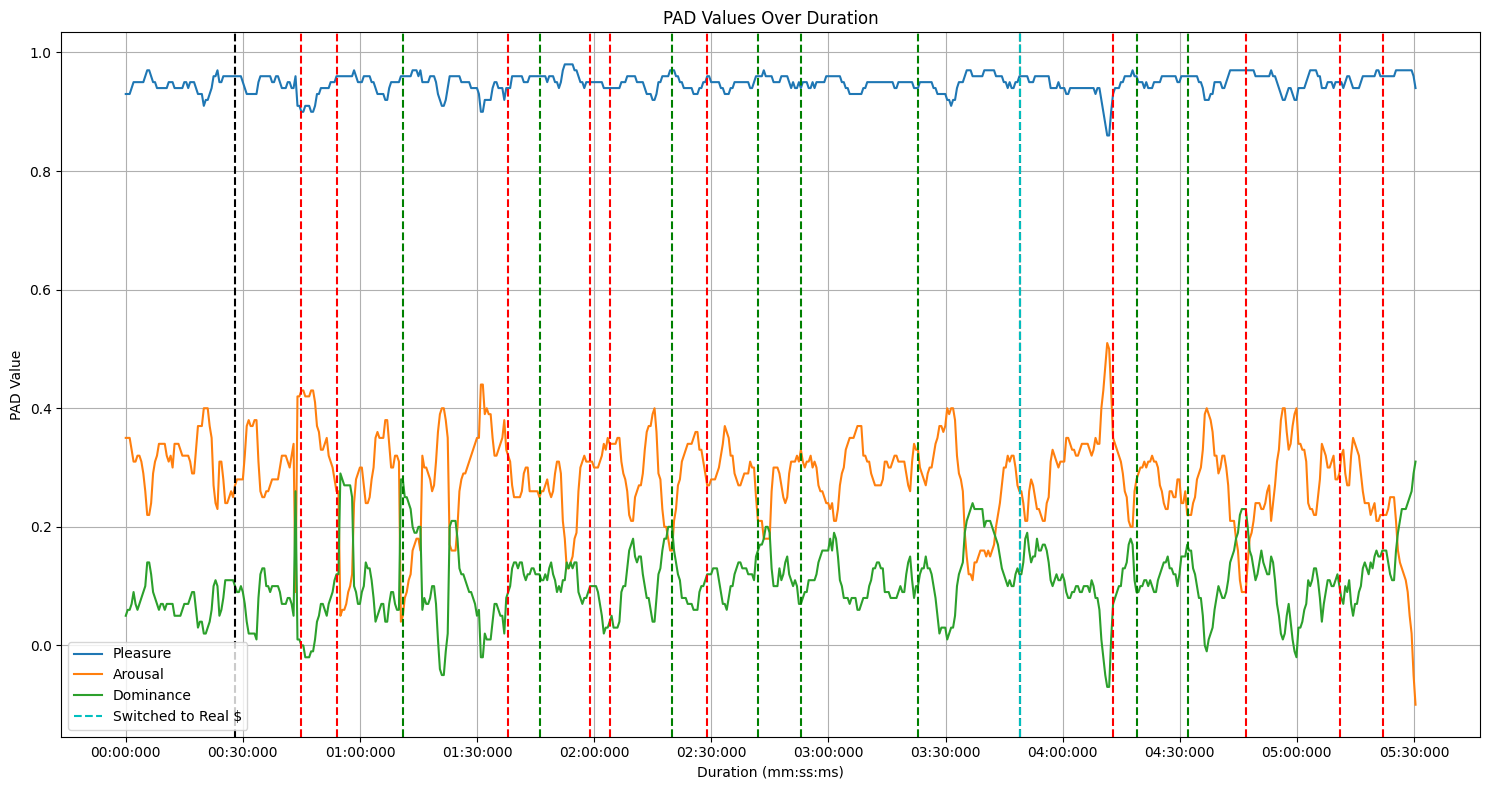

Pleasure
{'before_split': {'mean': 0.9475163398692809, 'variance': 0.0002077917629934078, 'std_dev': 0.014414983974788449}, 'after_split': {'mean': 0.9500492610837438, 'variance': 0.0002995025118275362, 'std_dev': 0.017306140870440648}}
{'t_statistic': -1.9566770684913577, 'p_value': 0.05080671181684439, 'statistically_significant': False}
Arousal
{'before_split': {'mean': 0.28843137254901957, 'variance': 0.005190110454662203, 'std_dev': 0.07204242121599054}, 'after_split': {'mean': 0.2732512315270936, 'variance': 0.006797297956396624, 'std_dev': 0.08244572733863546}}
{'t_statistic': 2.3891877642285118, 'p_value': 0.01716549286823906, 'statistically_significant': False}
Dominance
{'before_split': {'mean': 0.10311546840958605, 'variance': 0.0033835041051840527, 'std_dev': 0.058167895829091605}, 'after_split': {'mean': 0.11300492610837437, 'variance': 0.0034874603716529306, 'std_dev': 0.05905472353379474}}
{'t_statistic': -2.0076226115575313, 'p_value': 0.0450905405539803, 'statistically

In [75]:
# prompt: open the Ethan 2 folder and open each file for reading

import os

folder_path = '/content/drive/MyDrive/CSC 570 - Affective Computing/GamblingAffect/Ethan/Emotiv/Ethan 2'
switch = 229

# Check if the folder exists
if os.path.isdir(folder_path):
  # List all files in the folder
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    # Check if the path is a file
    if os.path.isfile(file_path):
      try:
        with open(file_path, 'r') as f:

          if filename == '250607144930_AFFECT.txt':
            plot_affect_over_duration(f, os.path.join(folder_path, 'aidanannotations.txt'),switch)
            f.seek(0)
            perform_statistical_analysis_affect(f, switch)

          elif filename == '250607144930_PAD.txt':
            plot_pad_over_duration(f, os.path.join(folder_path, 'aidanannotations.txt'), switch)
            f.seek(0)
            perform_statistical_analysis_pad(f, switch)

          elif filename == '250607144930_DEVICE.txt':
            plot_device_over_duration(f, switch)

      except Exception as e:
        print(f"Error opening or reading file {file_path}: {e}")
else:
  print(f"Folder not found: {folder_path}")

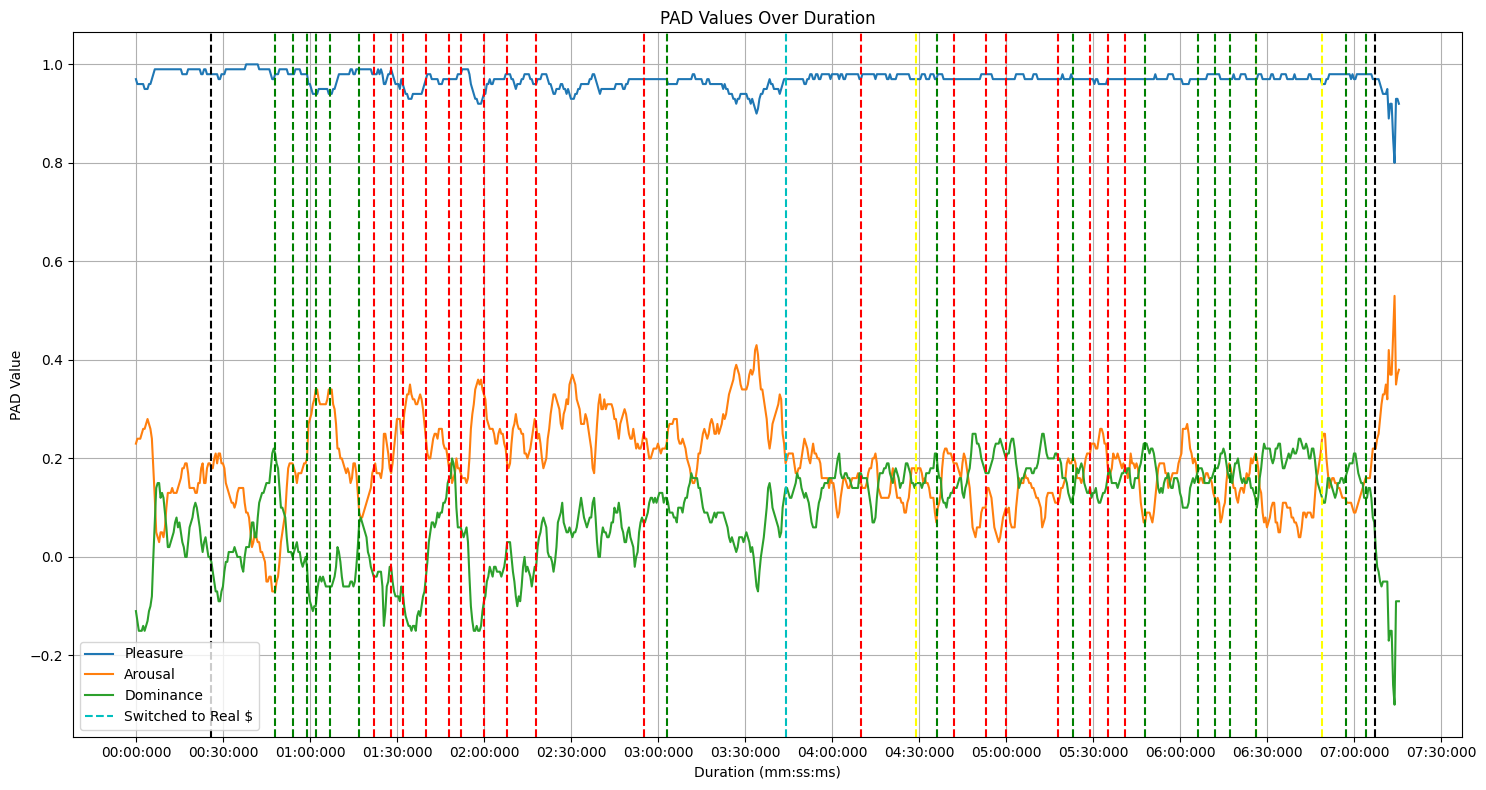

Pleasure
{'before_split': {'mean': 0.9669487750556792, 'variance': 0.0003569638880050914, 'std_dev': 0.01889348797880083}, 'after_split': {'mean': 0.9711347517730499, 'variance': 0.00018733487949984884, 'std_dev': 0.013687033261443066}}
{'t_statistic': -3.7274788098505796, 'p_value': 0.00020590550783432967, 'statistically_significant': True}
Arousal
{'before_split': {'mean': 0.22238307349665923, 'variance': 0.008213281498568223, 'std_dev': 0.09062715651816636}, 'after_split': {'mean': 0.15569739952718675, 'variance': 0.00411461911644427, 'std_dev': 0.06414529691601926}}
{'t_statistic': 12.473582029648819, 'p_value': 5.702240479325925e-33, 'statistically_significant': True}
Dominance
{'before_split': {'mean': 0.024565701559020048, 'variance': 0.006384688195991117, 'std_dev': 0.07990424391727335}, 'after_split': {'mean': 0.15517730496453896, 'variance': 0.004268629625894928, 'std_dev': 0.06533475052294091}}
{'t_statistic': -26.333236796406943, 'p_value': 7.474656088648161e-113, 'statisti

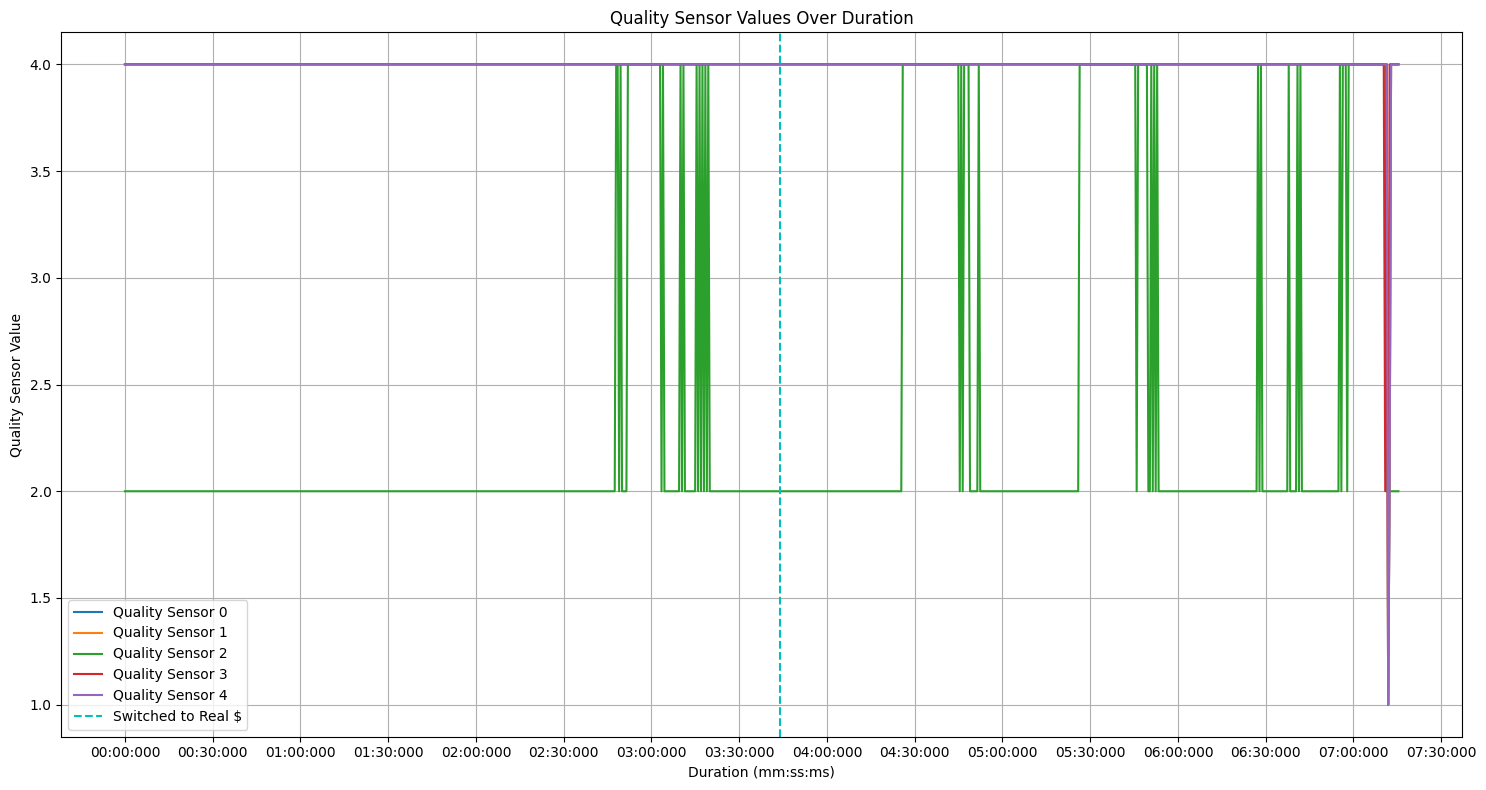

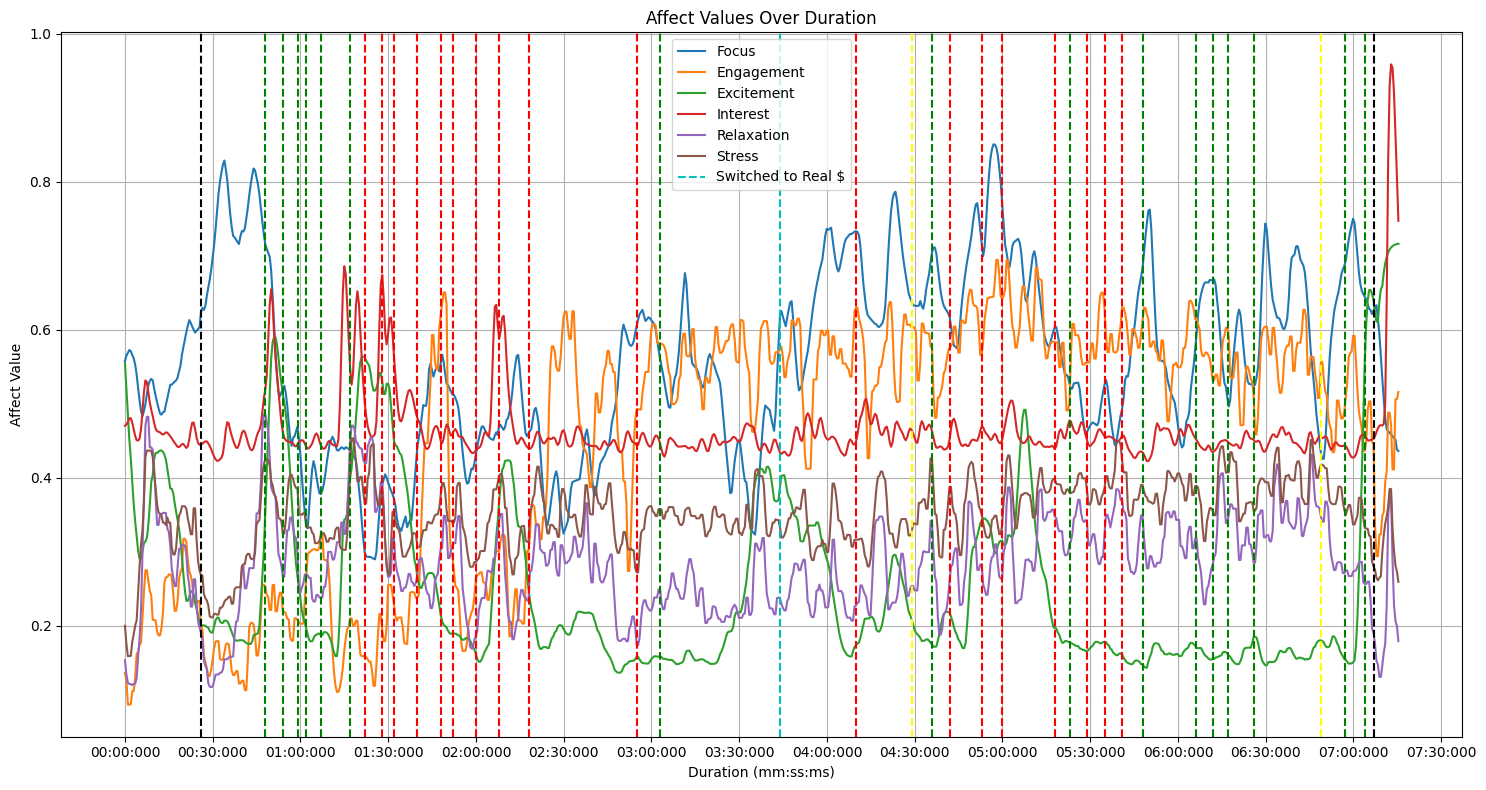

Focus
{'before_split': {'mean': 0.5013209777282851, 'variance': 0.013731662170200403, 'std_dev': 0.11718217513854401}, 'after_split': {'mean': 0.6220332464114833, 'variance': 0.008299932338497894, 'std_dev': 0.09110396444995077}}
{'t_statistic': -16.847481973834594, 'p_value': 2.7100896687585867e-55, 'statistically_significant': True}
Engagement
{'before_split': {'mean': 0.34532857461024496, 'variance': 0.028032511494535162, 'std_dev': 0.16742912379432429}, 'after_split': {'mean': 0.5623248061465722, 'variance': 0.0040521257885547494, 'std_dev': 0.06365630988798164}}
{'t_statistic': -25.00672527164323, 'p_value': 1.9959090043970203e-104, 'statistically_significant': True}
Excitement
{'before_split': {'mean': 0.2694671180400891, 'variance': 0.015055291155407899, 'std_dev': 0.12270000470826356}, 'after_split': {'mean': 0.24098455791962173, 'variance': 0.01660203552411927, 'std_dev': 0.12884888639068354}}
{'t_statistic': 3.343561480676724, 'p_value': 0.0008624348855435281, 'statistically_

In [69]:
# prompt: open the Ethan 3 folder and open each file for reading

import os

folder_path = '/content/drive/MyDrive/CSC 570 - Affective Computing/GamblingAffect/Ethan/Emotiv/Ethan 3'
switch = 224
# Check if the folder exists
if os.path.isdir(folder_path):
  # List all files in the folder
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    # Check if the path is a file
    if os.path.isfile(file_path):
      try:
        with open(file_path, 'r') as f:

          if filename == '250607145853_AFFECT.txt':
            plot_affect_over_duration(f, os.path.join(folder_path, 'kaiannotations.txt'), switch)
            f.seek(0)
            perform_statistical_analysis_affect(f, switch)

          elif filename == '250607145853_PAD.txt':
            plot_pad_over_duration(f, os.path.join(folder_path, 'kaiannotations.txt'), switch)
            f.seek(0)
            perform_statistical_analysis_pad(f, switch)

          elif filename == '250607145853_DEVICE.txt':
            plot_device_over_duration(f, switch)

      except Exception as e:
        print(f"Error opening or reading file {file_path}: {e}")
else:
  print(f"Folder not found: {folder_path}")

# FINAL RESULTS

------
## P1
------

__EEG:__
Sensor 2 was not connected throughout the recording which affected the focus and excitement classifications. The focus reading was -1 the entire trial, while I believe the polarity of the excitement reading is reverse. To correct the excitement reading, one idea would be to reflect all values across a mean line. However, I am unsure if this is reliable. For now, I filtered out these values so that they do not distract the audience from real data.

Some general trends noticed in the PAD data were positive correlations in arousal with wins and losses. This means that the more the participant won the higher the arousal and the morre the participant lost the lower the arousal. These effects are not single event changes but increase/decrease with repeated results. Excitement had higher volatility when the participant used real money compared to using fake money. Interest had larger values towards the beginning of each trial and generally declined over time, but had large spikes when user won multiple hands in the real money trial.

__Eye tracking:__
Eye tracking data was ommitted due to inaccurate calibration. The predictions were fixated on keyboard and lower screen most of the collection and did not display the more dynamic movements seen in the other eye tracking collections. It was evident that participant would frequently shake head side to side after losses.

__Statistics:__
All affect labels (excluding "Focus" due to aforementioned reasons) and PAD categories had statistically significant differences with fake money and real money with an alpha value of 0.01.

__Other:__
Cannot determine balance checks due to eye tracking miscalibration.

Fake record: 8-10-1

Real record: 12-7-2

------
## P2
------

__EEG:__
Sensor 2 had volatile connection up until 1:40. This has clear affect on the focus reading in the affect chart. Therefore, this noise was dropped from the chart. There is one large spike that shows across the arousal, dominance, and excitement charts that corresponded to a late lost in the real money trial. There are huge spikes in excitement accoss both trials are primarily correlated with losses. When the participant lost all their real money there was a large shift of arousal in the negative direction and dominance in the positive direction. This state corresponds with relaxation which shows a sharp increase at the same time. This is unexpected after losing money and one could expect even negative pleasure in this state which combined with the current arousal and dominance would product disdain which would be appropriate. No noticeable drops in pleasure were observed among all participants.

__Eye tracking:__
9 balance checks on fake, most often after loss and look at audience after each win minus 2 samples. 12 balance checks on real money, often double checking balance after each hand, less gaze of audience. Participant had extreme head movements at times after losses which included head rolls and after wins which included vertical head nods.

__Statistics:__
All affect labels (excluding "Focus" due to aforementioned reasons) and none of the PAD categories had statistically significant differences with fake money and real money with an alpha value of 0.01.

__Other:__

Fake record: 6-6

Real record: 2-4

--------
## P3
--------

__EEG:__
There is some volatility in the sensor 2 connection, however, the quality of the signal is always above 2, so data collection from this sensor can be trusted. Slight negative trend in pleasure over whole recording, lower baseline of pleasure compared to other participants. Large positive trends with increasing focus, engagement, and stress over whole recording. Large spikes of excitement following multiple losses or multiple wins. Often, prompted user to change betting pattern. Large spikes of interest in the fake money trial due to experimentation with betting patterns and learning the gaming interface.

__Eye tracking:__
11 balance checks after every bout of betting with fake money no correlation with game play but when spamming balls monitored balance. 12 balance with real money;checks 5 after loss and 6 after win and 1 after push.

__Statistics:__
All affect labels and PAD categories had statistically significant differences with fake money and real money with an alpha value of 0.01.

__Other:__

Fake record: 7-9

Real record: 9-8-3

------
## Results
------

* Some equipment was not properly calibrated or recording properly, namely, the EEG sensors located on the forehead
* No noticable drops in pleasure across participants (all highly positive pleasure, lowest recorded value ~0.88) => generally, participants had fun playing regardless of stakes
* Affective states are different among all participants when playing with fake money vs. real money
* Higher volatility (related to variance bounded in a certain time) of affective states when playing with real money